<a href="https://colab.research.google.com/github/syoung7388/DeepLearningBasicModel/blob/main/1_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP**

**[Overview]**
1. 라이브러리 설정 
2. HyperParameter 설정 
3. GPU 설정 
4. Data 준비
5. 모델 설계 
6. 모델 훈련 (Training)
7. 모델 검증 (Testing)

**1. 라이브러리**

In [ ]:
import torch #pytorch 사용
import torch.nn as nn # neural network library from pytorch 사용 
import torch.nn.functional as F # pytorch 내부의 F 함수 사용
import torch.optim as optim # optimizer 사용
from torchvision import datasets, transforms  #dataset 불러오기 위해 사용 
import matplotlib.pyplot as plt # 시각화를 위한 matplotlib 사용
from torch.utils.data import DataLoader #Data를 batch_size로 나누기 위해 사용 
from tqdm.notebook import tqdm 

**2. HyperParameter**

   - Parameter 
     * Parameter는 모델 내부에서 결정되는 변수 
     * 훈련 가능한 weight, bias 
   - HyperParameter 
     * 모델링 할 때 사용자가 직접 세팅해주는 값 

In [ ]:
epochs= 10
batch_size= 64
lr= 1e-4
dropout= 0.2
n_class= 10

# seed 
seed= 9712 
torch.manual_seed = seed  #매번 같은 결과 값이 나오게 함

**3. GPU 설정**
 - cpu: 최대 24코어 
 - gpu: 단순한 연산(floating point) 덧셈 뺄셈 곱셈 나눗셈만 이것만 전문으로 하는 코어들을 수천개씩 가지고 있다 
 - 딥러닝은 기본적으로 행렬 곱하기 연산이기 때문에 딥러닝에는 gpu가 적합하다 

In [ ]:
! nvidia-smi
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Tue Aug  2 04:21:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**4. Data 준비**
   - Dataset  
     * Dataset class는 전체 dataset을 구성하는 단계
     * __init__(self)
     * __get_item__(self, index)
     *__len__(self)
   - DataLoader 
     * Dataloader class는 batch기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다. 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

5


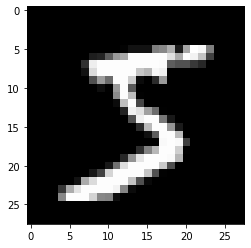

In [ ]:

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())
sample_data, label = train_dataset[0]

plt.imshow(sample_data.reshape((28, 28)), cmap='gray')
print(label)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"[Dataset] train: {len(train_dataset)}, test: {len(test_dataset)}")
print(f"[DataLoader] train: {len(train_dataloader)}, test: {len(test_dataloader)}")

[Dataset] train: 60000, test: 10000
[DataLoader] train: 938, test: 10000


**5. Model 설계**

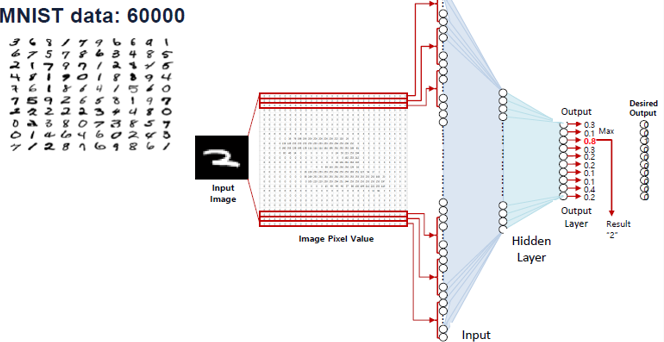

   - nn.Linear: 저장된 weight와 bias를 사용하여 선형 변환을 적용하는 모듈 
   - nn.Softmax: 모델의 각 분류(class)에 대한 예측 확률을 나타내도록 [0, 1] 범위로 비례하여 조정(scale)됩니다.
   - nn.Dropout: overfitting을 해결할 수 있는 방법 중 하나로, 일부 파라미터를 학습에 반영하지 않음 
   - F.relu: f(x) = max(x, 0)

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_class, dropout):
        super(MLP, self).__init__()
        self.linear1= nn.Linear(784, 512)
        self.linear2= nn.Linear(512, 512)
        self.classifier_layer= nn.Linear(512, n_class)
        self.softmax= nn.Softmax(dim=1)      
        self.dropout= nn.Dropout(dropout)
    def forward(self, x):
        x= self.dropout(F.relu(self.linear1(x.view(-1, 784))))
        x= self.dropout(F.relu(self.linear2(x)))
        output= self.classifier_layer(x)
        return self.softmax(output)

#model 불러오기
model = MLP(n_class, dropout).to(device)



print("[모델 구조]")
print(model)
print()
print("[Linear1  weights]")
print(model.linear1.weight.size())
print()
print("[Linear1  bias]")
print(model.linear1.bias.size())

[모델 구조]
MLP(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (classifier_layer): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

[Linear1  weights]
torch.Size([512, 784])

[Linear1  bias]
torch.Size([512])


**6. Model 훈련(Training)**

* 모델 훈련? 
  -  모델 안에 있는 Parameter(weights, bias)의 최적의 값을 찾는것이다. 

* 모델 훈련 과정? 
  - Forward 
  - Backward
  - Optimizer.step()

* Loss Function: Cross Entropy ?


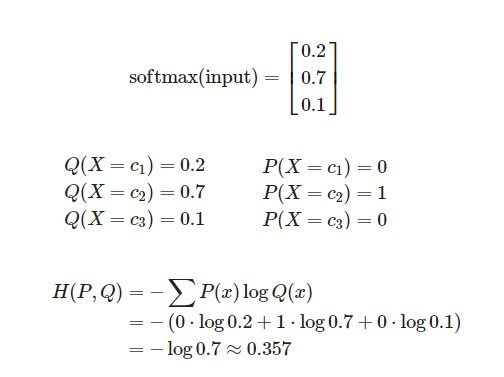

* Optimizer?
 - 딥러닝에서 모델을 학습시킨다는건 최적화(optimization) task를 수행하는 것
 - 최적화란, 정의된 손실 함수(loss funciton)의 최솟값을 찾아나가는 일련의 과정
 - 최적화 단계 수행 모든 옵티마이저는 step() 메소드에서 수행

In [ ]:

loss_fn= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=lr)

tot_train_loss= []
model.train()
for e in range(1, epochs+1):
    print(f"============= [Epochs] {e}/{epochs} =============")
    train_loss= 0.0
    for datas, labels in tqdm(train_dataloader):
        datas= datas.to(device)
        labels= labels.to(device)

        output= model(datas)
        loss= loss_fn(output, labels)
        train_loss += loss.item()

        optimizer.zero_grad()        
        loss.backward()
        optimizer.step()
    tot_train_loss.append(train_loss/len(train_dataloader))
    print(f"Loss: {train_loss/len(train_dataloader):.6f}")

============= [Epochs] 1/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.696863
============= [Epochs] 2/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.558729
============= [Epochs] 3/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.540733
============= [Epochs] 4/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.529827
============= [Epochs] 5/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.520873
============= [Epochs] 6/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.514677
============= [Epochs] 7/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.509350
============= [Epochs] 8/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.504612
============= [Epochs] 9/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.501263
============= [Epochs] 10/10 =============


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.497643


**7. Model 검증(Testing)**
* 모델이 잘 학습되었는지 검증

In [ ]:
with torch.no_grad(): # autograd 엔진을 비활성화 
    model.eval() # dropout을 비활성화 시켜줌
    test_acc= 0.0
    for datas, labels in tqdm(test_dataloader):
        
        datas= datas.to(device)
        labels= labels.to(device)
        
        output= model(datas)
        
        preds= torch.argmax(output, dim=1)
        test_acc+= preds.eq(labels).sum()

print(f"[Test Result] {(test_acc/len(test_dataloader.dataset))*100:.3f}%")

  0%|          | 0/10000 [00:00<?, ?it/s]

[Test Result] 96.600%
